Změny oproti předešlé verzi
- přidán druhý slovník s popisky pro vnější část grafu
- do celkovýho grafu zařazeny všechny proměnné
- vnější kus grafu seskládán podle vnitřního

Ptej se na:
- barvy grafu
- vnější okruh grafu - seřazení - nejde hezčejc?
- slovník popisků: musí mít stejný počet hodnot jako je položek grafu aby se to zobrazilo?
- změny polohy popisků a procent v grafu
- "geo\\time" - nejde líp?
- graf 1: co to je add_artist?
- jak upravit název grafu tak aby to správně zobrazilo stát a rok 

Import modulů

In [1003]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eurostat

## Zvol ROK a STÁT

In [1004]:
YEAR = 2018 
STATE = 'SK'  

Popisky



In [1005]:
label_dict_1 = {'CRF2':'Průmyslové procesy (výroba cementu, oceli,...)', 
              'CRF1A3|CRF1D1A':'Doprava (včetně letecké)',
              'CRF1A2':'Spalování v průmyslu', 
              'CRF1A1':'Energetika',
              'CRF1A4':'Spalování v domácnostech, institucích a zemědělství',
              'CRF3':'Zemědělství',
              'CRF5':'Odpadové hospodářství',
              'TOTX4_MEMONIA':'jiné'}

label_dict_2 = {'CRF2C':'Zpracování oceli a kovů',
              'CRF2A':'Minerální produkce (cement, vápno, ...)',
              'CRF2B':'Chemický průmysl',
              'CRF2_rozdil':'Další průmyslové procesy',
              'CRF1A3B1':'Osobní automobilová doprava',
              'CRF1A3B2|CRF1A3B3':'Nákladní a autobusová doprava',
              'CRF1D1A|CRF1A3A':'Letecká doprava',
              'CRF1A3_rozdil':'Jiná doprava',
              'CRF1A2A|CRF1A2B':'Spalování při zpracování oceli a kovů',
              'CRF1A2_rozdil':'Další spalování v průmyslu',
              'CRF1A1C|CRF1A1B':'Rafinace, výroba a úprava paliv',
              'CRF1A1_rozdil':'Teplárny'}


Stáhni dataframe "env_air_gge"

In [1006]:
df = eurostat.get_data_df('env_air_gge')

In [1007]:
df.head(2) # s kým mám tu čest... 

,unit,airpol,src_crf,geo\time,2020,2019,2018,2017,2016,2015,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
0,MIO_T,CH4,CRF1,AT,0.02177,0.02223,0.02289,0.02578,0.02442,0.02428,...,0.03347,0.04038,0.04278,0.04369,0.04858,NaN,NaN,NaN,NaN,NaN
1,MIO_T,CH4,CRF1,BE,0.04085,0.04232,0.04160,0.04206,0.04275,0.04287,...,0.04837,0.05451,0.05340,0.05934,0.06406,NaN,NaN,NaN,NaN,NaN


Přejmenuj sloupec ať se s tím dá pracovat

In [1008]:
df = df.rename(columns={'geo\\time': 'geo_time'}) # povšimni si těch dvou lomítek v "geo\\time" - Honza bez přejmenování ale 'geo\\time' hází chybu.

Dataframe pro Slovensko v milionech tun GHG CO2 ekvivalentu

In [1009]:
df2 = df.query("airpol == 'GHG' and geo_time == @STATE and unit == 'MIO_T'") 
df2.head(2)

,unit,airpol,src_crf,geo_time,2020,2019,2018,2017,2016,2015,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
13330,MIO_T,GHG,CRF1,SK,24.60852,26.84846,28.29565,28.44574,27.50871,27.34669,...,39.18166,41.64202,45.61166,49.84740,56.27949,NaN,NaN,NaN,NaN,NaN
13366,MIO_T,GHG,CRF1A,SK,24.18342,26.36847,27.83462,27.91228,26.94201,26.77401,...,36.93856,39.37876,43.26013,47.46876,53.86689,NaN,NaN,NaN,NaN,NaN


Data frame pro kod odvětví (src_crf) a rok.

In [1010]:
df3 = df2[["src_crf", YEAR]] 

Vybírám jen určitá odvětví

In [1011]:
df4 = df3.query("src_crf in ('CRF2', 'CRF1A2', 'CRF1A1','CRF1A4','CRF5','CRF3','CRF1A3','CRF1D1A' )") 

Nastav sloupec "src_crf" jako index

In [1012]:
df4 = df4.set_index('src_crf') 

## Výpočty nových hodnot

Sečti dvě odvětví (CRF1A3 a CRF1D1A) a přidej je do tabulky

In [1013]:
A = df4.loc['CRF1A3', YEAR] 
B = df4.loc['CRF1D1A', YEAR] 
C = A+B

In [1014]:
C_df = pd.DataFrame({YEAR:[C]}) # vytvoř nový dataframe se sloupcem pojm. "YEAR", indexem 0 a hodnotou vypoč. jako "C"
df4 = df4.append(C_df) # přilep nový dataframe ke stávajícímu 
df4 = df4.rename(index={0: 'CRF1A3_CRF1D1A'}) # přejmenuj index

Vyhoď jednotlivý řádky pro CRF1A3 a CRF1D1A ať to není zastoupený 2x

In [1015]:
df4 = df4.drop(index = 'CRF1A3') 
df4 = df4.drop(index = 'CRF1D1A')

### Dopočítej rozdíl do celku

Získej hodnotu pro celek za zvolený rok

In [1016]:
df5 = df2.query("src_crf == 'TOTX4_MEMONIA'")
df5 = df5.set_index('src_crf') # sloupec s kodem odvětví nastav jako index
D = df5.loc['TOTX4_MEMONIA', YEAR] 

Sečti sloupec za zvolený rok, vypočítej rozdíl a přidej řádek

In [1017]:
total = df4[YEAR].sum() # sečti sloupec
jine = D - total

In [1018]:
jine_df = pd.DataFrame({YEAR:[jine]})

In [1019]:
df4 = df4.append(jine_df) # přilep nový dataframe ke stávajícímu 
df4 = df4.rename(index={0: 'jine'}) # přejmenuj index

Poskládej to sestupně

In [1020]:
df4 = df4.sort_values(by= [YEAR], ascending=False)

### Vytvoř graf

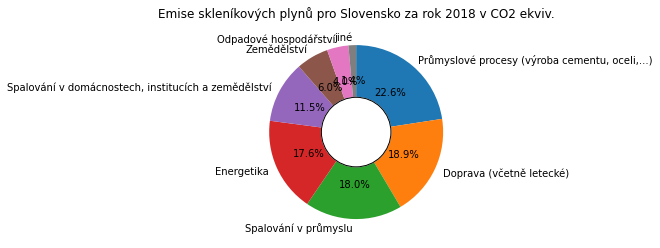

In [1021]:
_, ax = plt.subplots() 
plt.title('Emise skleníkových plynů pro Slovensko za rok 2018 v CO2 ekviv.')
plt.pie(df4[YEAR], labels = label_dict_1.values(), counterclock=False, startangle=90, autopct='%1.1f%%')
inner_circle_fill = plt.Circle((0, 0), 0.4, color='white') # nastavení vnitřního kruhu
inner_circle_edge = plt.Circle((0, 0), 0.4, color='black', fill=False) # nastavení okraje vnitřního kruhu
ax.add_artist(inner_circle_fill) # "add_artist" vidim prvně
ax.add_artist(inner_circle_edge)
plt.show() 

# proč ty popisky grafu správně berou "CRF1A3_CRF1D1A" i když ve slovníku je to klíčovaný jinak?
# jak se do toho grafu dostal popisek "jiné" když hodnota pro TOTX4_MEMONIA v tom df není...?
# upravit název grafu tak aby to správně zobrazilo stát a rok 


## Graf 2

In [1022]:
df_outer = df3.query("src_crf in ('CRF2C', 'CRF2A', 'CRF2B','CRF1A3B1','CRF1A3B2','CRF1A3B3','CRF1D1A','CRF1A3A','CRF1A1C','CRF1A1B','CRF1A2A','CRF1A2B')") 
df_outer = df_outer.set_index('src_crf') 

Úpravy a dopočty dalších buněk pro graf.

In [1023]:
# Uprav df_outer: vytvoř tohle: CRF1A3B2|CRF1A3B3 
D = df_outer.loc['CRF1A3B2', YEAR] + df_outer.loc['CRF1A3B3', YEAR] 
D_df = pd.DataFrame({YEAR:[D]}) # vytvoř nový dataframe se sloupcem pojm. "YEAR", indexem 0 a hodnotou vypoč. jako "D"
df_outer = df_outer.append(D_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1A3B2_CRF1A3B3'}) # přejmenuj index
df_outer = df_outer.drop(index = 'CRF1A3B2') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A3B3')

In [1024]:
# Uprav df_outer: vytvoř tohle: CRF1D1A|CRF1A3A
E = df_outer.loc['CRF1D1A', YEAR] + df_outer.loc['CRF1A3A', YEAR] 
E_df = pd.DataFrame({YEAR:[E]}) # vytvoř nový dataframe se sloupcem pojm. "YEAR", indexem 0 a hodnotou vypoč. jako "E"
df_outer = df_outer.append(E_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1D1A_CRF1A3A'}) # přejmenuj index
df_outer = df_outer.drop(index = 'CRF1D1A') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A3A') # zahoď původní hodnotu

In [1025]:
# Uprav df_outer: vytvoř tohle: CRF1A2A|CRF1A2B
F = df_outer.loc['CRF1A2A', YEAR] + df_outer.loc['CRF1A2B', YEAR]
F_df = pd.DataFrame({YEAR:[F]}) # vytvoř nový dataframe se sloupcem pojm. "YEAR", indexem 0 a hodnotou vypoč. jako "F"
df_outer = df_outer.append(F_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1A2A_CRF1A2B'}) # přejmenuj index
df_outer = df_outer.drop(index = 'CRF1A2A') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A2B') # zahoď původní hodnotu

In [1026]:
# Uprav df_outer: vytvoř tohle: CRF2_rozdil. Tedy: "další prům proc" = CRF2 - (CRF2A + CRF2B + CRF2C)
G = df_outer.loc['CRF2A', YEAR] + df_outer.loc['CRF2B', YEAR] + df_outer.loc['CRF2C', YEAR]
H = df4.loc['CRF2', YEAR] - G
H_df = pd.DataFrame({YEAR:[H]})
df_outer = df_outer.append(H_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF2_rozdil'}) # přejmenuj index

In [1027]:
# Uprav df_outer: vytvoř tohle: CRF1A2_rozdil. Tedy: "další spalování v průmyslu" = CRF1A2 - CRF1A2A_CRF1A2B
I = df4.loc['CRF1A2', YEAR] - df_outer.loc['CRF1A2A_CRF1A2B', YEAR]
I_df = pd.DataFrame({YEAR:[I]})
df_outer = df_outer.append(I_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1A2_rozdil'}) # přejmenuj index

In [1028]:
# Uprav df_outer: vytvoř tohle: CRF1A1C_CRF1A1B. Tedy: "rafinace a spol" = CRF1A1C + CRF1A1B
J = df_outer.loc['CRF1A1C', YEAR] + df_outer.loc['CRF1A1B', YEAR]
J_df = pd.DataFrame({YEAR:[J]})
df_outer = df_outer.append(J_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1A1C_CRF1A1B'}) # přejmenuj index
df_outer = df_outer.drop(index = 'CRF1A1C') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A1B') # zahoď původní hodnotu

In [1029]:
# Uprav df_outer: vytvoř tohle: CRF1A3_rozdil. Tedy = CRF1A3_CRF1D1A - (CRF1A3B1 + CRF1A3B2_CRF1A3B3 + CRF1D1A_CRF1A3A)
K = df4.loc['CRF1A3_CRF1D1A', YEAR] - (df_outer.loc['CRF1A3B1', YEAR] + df_outer.loc['CRF1A3B2_CRF1A3B3', YEAR] + df_outer.loc['CRF1D1A_CRF1A3A', YEAR])
K_df = pd.DataFrame({YEAR:[K]})
df_outer = df_outer.append(K_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1A3_rozdil'}) # přejmenuj index

In [1030]:
# Tohle je DÍLČÍ ROZDÍL. Ještě příde dál rozpadnout. 
# Uprav df_outer: vytvoř tohle: CRF1A1_rozdil_X. Tedy CRF1A1_rozdil_X = CRF1A1 - CRF1A1C_CFR1A1B
L = df4.loc['CRF1A1', YEAR] - df_outer.loc['CRF1A1C_CRF1A1B', YEAR]
L_df = pd.DataFrame({YEAR:[L]})
df_outer = df_outer.append(L_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1A1_rozdil_X'}) # přejmenuj index

In [1031]:
# přidat hodnoty z vnitřního grafu
M = df4.loc['CRF1A4', YEAR] # spalování v domácnostech ... 
N = df4.loc['CRF3', YEAR] # zemědělství
O = df4.loc['CRF5', YEAR] # odpadové hospodářství
P = df4.loc['jine', YEAR] # jiné

M_df = pd.DataFrame({YEAR:[M]})
df_outer = df_outer.append(M_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF1A4'}) # přejmenuj index

N_df = pd.DataFrame({YEAR:[N]})
df_outer = df_outer.append(N_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF3'}) # přejmenuj index

O_df = pd.DataFrame({YEAR:[O]})
df_outer = df_outer.append(O_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'CRF5'}) # přejmenuj index

P_df = pd.DataFrame({YEAR:[P]})
df_outer = df_outer.append(P_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.rename(index={0: 'jine'}) # přejmenuj index

seřadit tak jak chci já

In [1032]:
# teď sem tam napevno vrazil hodnoty podle kterejch to řadim, nešlo by to nějak hezčejác?
sorting_values = [5,2,3,1,6,7,9,4,10,11,8,12,13,14,15,16] # vytvoř list
df_outer['sorting_values'] = sorting_values # přidej ho do dataframu

In [1033]:
# potřeba seřadit tak jak chci aby to lezlo do toho grafu. 
df_outer.sort_values('sorting_values', inplace=True)

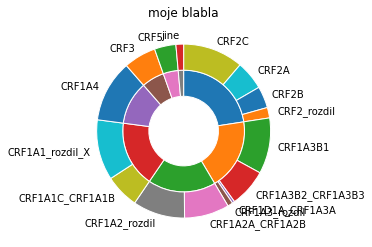

In [1034]:
fig, ax = plt.subplots()

size = 0.3

# vnitřní
ax.pie(df4[YEAR], radius=1-size, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

# vnější
ax.pie(df_outer[2018], radius=1, labels = df_outer.index, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='moje blabla')
plt.show()

# CRF1A1_rozdil_X bude ještě nutno dál rozpadnout: elektrárny - povolenky, teplárny... a to nebude úplně lehký

## Další provozní kusy kodu

Graf 2: Na pevno - ať vidim ja to má vypadat

In [1035]:
d = {'col1': ['CRF2C', 'CRF2A', 'CRF2B', 'dalsi', 'zbytek'], 'col2': [4.75, 2.28, 1.7, 0.88, 32.7] } # zatim napevno
df_outer_demo = pd.DataFrame(data=d)

In [1036]:
df_outer_demo = df_outer_demo.set_index('col1')

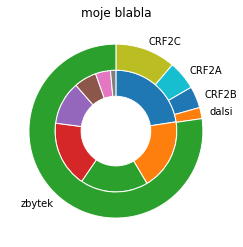

In [1037]:
fig, ax = plt.subplots()

size = 0.3

# vnitřní
ax.pie(df4[YEAR], radius=1-size, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

# vnější
ax.pie(df_outer_demo['col2'], radius=1, labels = df_outer_demo.index, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='moje blabla')
plt.show()

Další kousky

In [1038]:
total = df4[YEAR].sum() # sečti sloupec
total

42.32090999999999

In [1039]:
print (df4[YEAR].dtypes) # zjisti datový typ sloupce

float64


In [1040]:
list(df3.columns) # vyjeď názvy sloupců

['src_crf', 2018]

In [1041]:
df.airpol.unique() # ukáže mi co unikátního tam všechno mám 

array(['CH4', 'CH4_CO2E', 'CO2', 'GHG', 'HFC_CO2E', 'HFC_PFC_NSP_CO2E',
       'N2O', 'N2O_CO2E', 'NF3_CO2E', 'PFC_CO2E', 'SF6_CO2E'],
      dtype=object)

## Další tabulka

In [1042]:
df_demo = eurostat.get_data_df('demo_pjan')

In [1043]:
df_demo.head(2)

,unit,age,sex,geo\time,2021,2020,2019,2018,2017,2016,...,1969,1968,1967,1966,1965,1964,1963,1962,1961,1960
0,NR,TOTAL,F,AD,NaN,NaN,37388.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NR,TOTAL,F,AL,1419759.0,1425342.0,1432833.0,1431715.0,1423050.0,1417141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
